In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5.dev0


# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

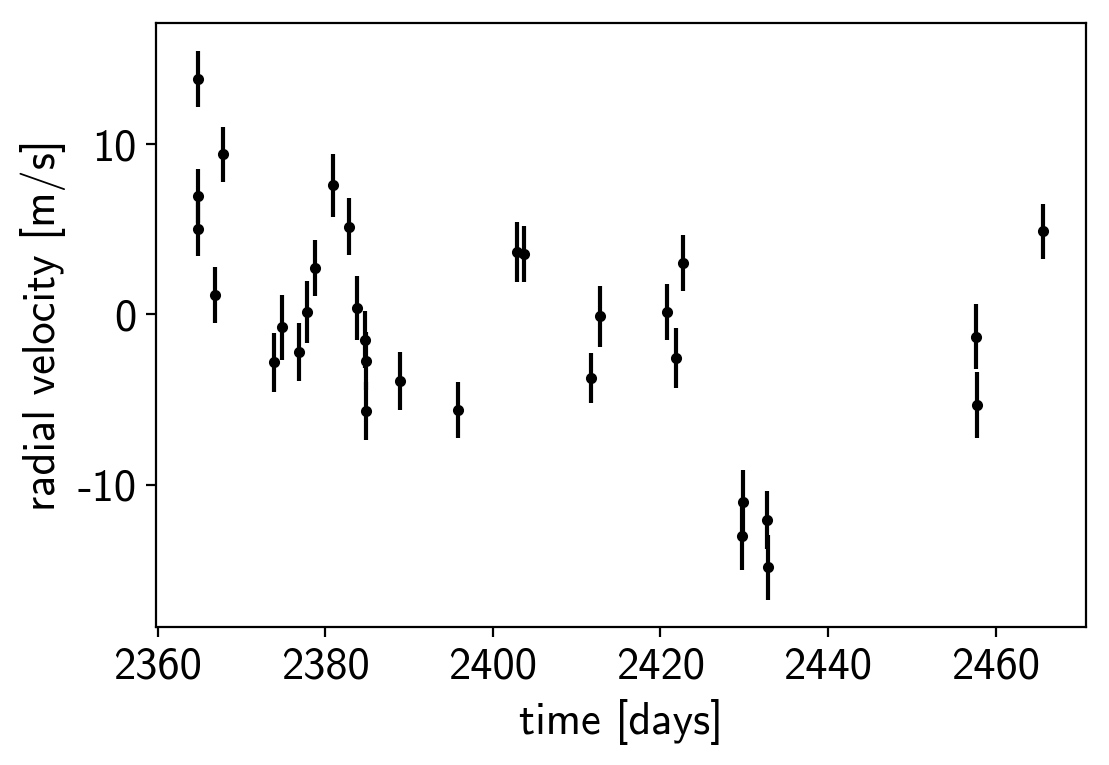

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                     testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2, testval=np.zeros(2))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

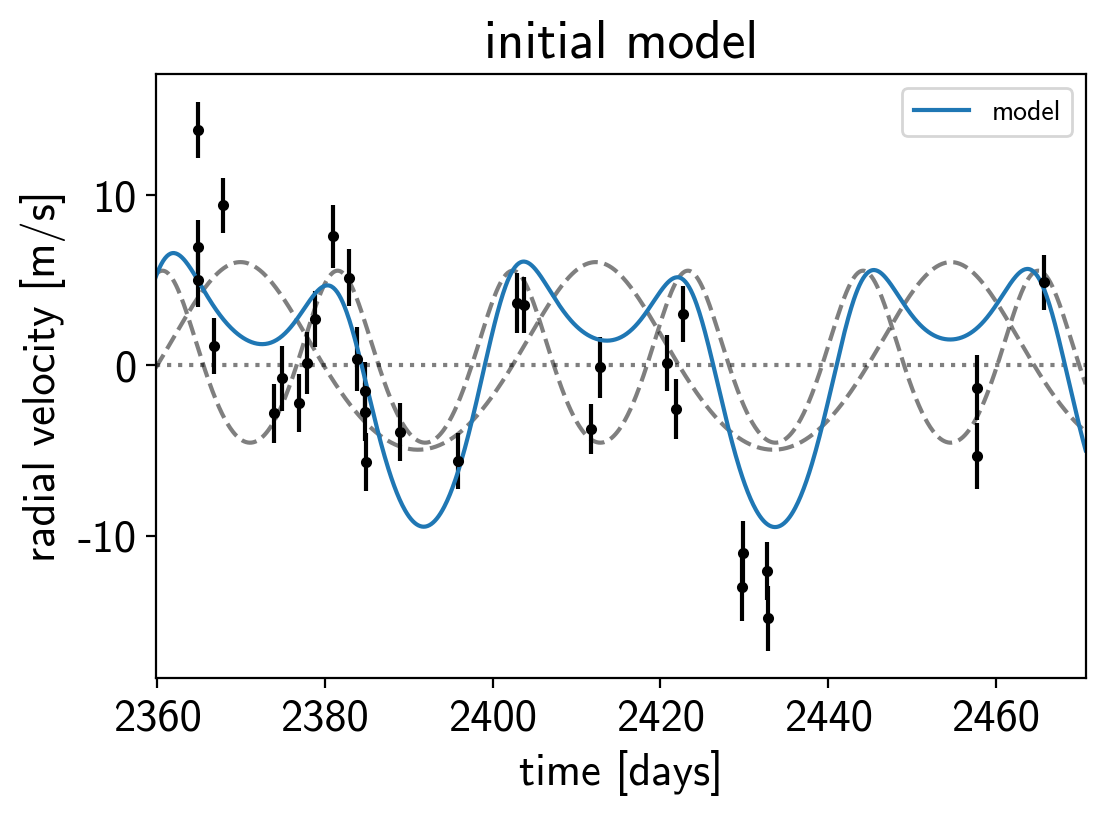

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -87.51672438985798 -> -72.63226415698486


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_interval__', 'logK', 'P', 't0']


message: Desired error not necessarily achieved due to precision loss.
logp: -72.63226415698486 -> -22.056179633452878


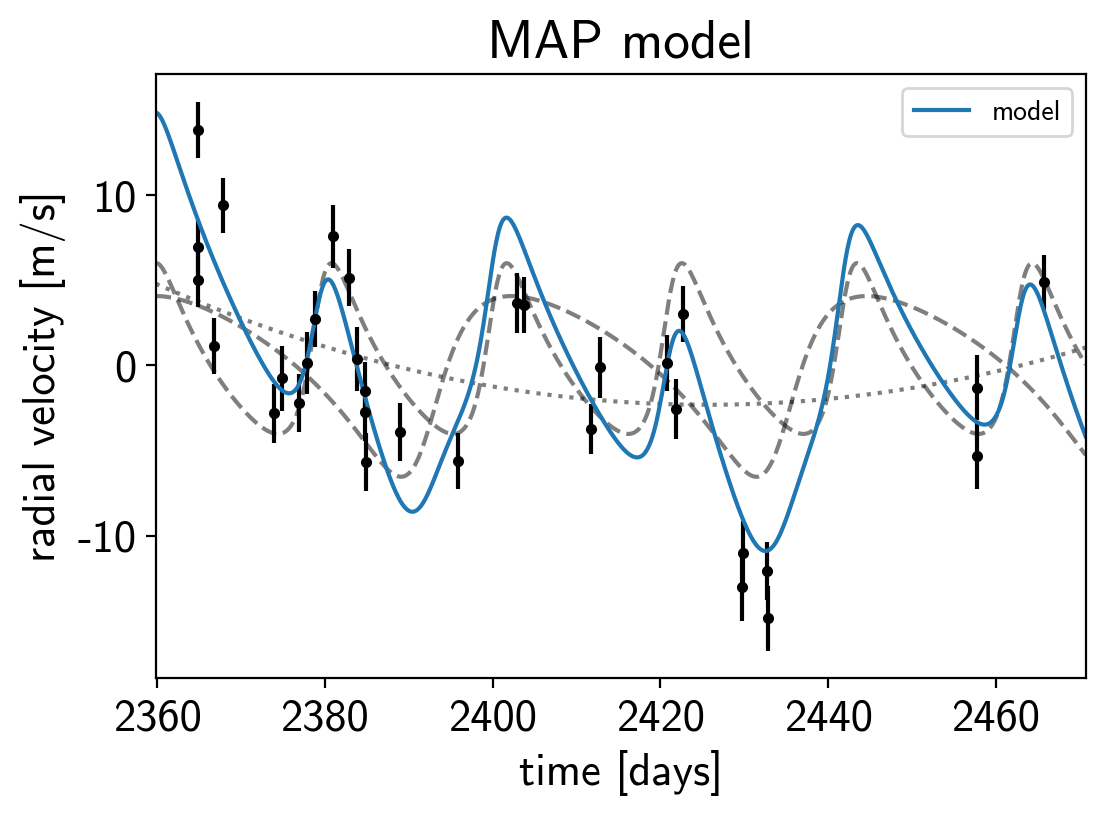

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=3000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:04, 160.79draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:06, 120.56draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:07, 102.78draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:08, 93.15draws/s] 

Sampling 4 chains:   6%|▋         | 52/808 [00:00<00:09, 83.33draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:00<00:09, 81.08draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:00<00:09, 79.57draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:00<00:09, 78.56draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:00<00:09, 77.91draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:09, 77.47draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:01<00:09, 77.19draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:01<00:09, 76.99draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:01<00:09, 76.84draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:01<00:09, 75.68draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:01<00:09, 74.48draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:01<00:09, 73.65draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:01<00:08, 73.94draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:01<00:08, 76.08draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:02<00:08, 75.24draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:02<00:08, 74.26draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:02<00:08, 74.64draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:02<00:08, 75.05draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:02<00:08, 75.63draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:02<00:08, 74.92draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:02<00:07, 75.62draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:02<00:07, 76.18draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:02<00:07, 76.57draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:02<00:07, 76.46draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:03<00:07, 75.49draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:03<00:07, 74.44draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:03<00:07, 75.08draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:03<00:07, 75.49draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:03<00:07, 75.81draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:03<00:06, 76.03draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:03<00:06, 76.22draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:03<00:06, 76.34draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:03<00:06, 74.98draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:04<00:06, 71.70draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:04<00:06, 73.14draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:04<00:06, 72.79draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:04<00:06, 73.70draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:04<00:06, 74.40draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:04<00:06, 74.38draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:04<00:05, 74.64draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:04<00:05, 75.09draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:04<00:05, 75.36draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:05<00:05, 75.56draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:05<00:05, 75.85draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:05<00:05, 76.09draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:05<00:05, 75.63draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:05<00:05, 75.82draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:05<00:04, 76.17draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:05<00:04, 76.34draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:05<00:04, 76.04draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:05<00:04, 76.27draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:05<00:04, 75.22draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:06<00:04, 75.73draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:06<00:04, 76.12draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:06<00:04, 76.35draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:06<00:04, 76.54draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:06<00:04, 76.62draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:06<00:03, 76.69draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:06<00:03, 76.77draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:06<00:03, 76.36draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:06<00:03, 75.34draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:07<00:03, 74.57draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:07<00:03, 74.06draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:07<00:03, 71.35draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:07<00:03, 71.74draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:07<00:03, 71.92draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:07<00:03, 72.33draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:07<00:02, 73.65draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:07<00:02, 74.64draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:07<00:02, 75.35draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:08<00:02, 75.75draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:08<00:02, 76.08draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:08<00:02, 76.33draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:08<00:02, 76.45draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:08<00:02, 76.61draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:08<00:02, 76.19draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:08<00:01, 75.67draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:08<00:01, 74.80draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:08<00:01, 75.36draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:08<00:01, 75.92draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:09<00:01, 75.51draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:09<00:01, 75.83draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:09<00:01, 76.07draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:09<00:01, 76.29draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:09<00:01, 76.44draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:09<00:00, 76.52draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:09<00:00, 76.39draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:09<00:00, 73.14draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:09<00:00, 74.03draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:10<00:00, 74.72draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:10<00:00, 75.25draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [00:10<00:00, 75.55draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:10<00:00, 75.61draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:10<00:00, 61.11draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:10<00:00, 48.40draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:11<00:00, 72.11draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 165.31draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:03, 122.51draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:03, 99.23draws/s] 

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:03, 91.15draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:03, 92.17draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:00<00:03, 86.81draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:00<00:03, 86.62draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:00<00:03, 86.54draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:00<00:03, 86.46draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:01<00:03, 88.29draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:01<00:03, 87.09draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:01<00:03, 89.58draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:01<00:03, 84.63draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:01<00:03, 82.80draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:01<00:03, 83.54draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:01<00:02, 86.62draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:01<00:02, 85.75draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:01<00:02, 89.51draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:02<00:02, 85.65draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:02<00:02, 85.56draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:02<00:02, 84.52draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:02<00:02, 78.67draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:02<00:02, 78.21draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:02<00:02, 82.10draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:02<00:01, 85.84draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:02<00:01, 82.22draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:02<00:01, 83.19draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:03<00:01, 84.27draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:03<00:01, 84.61draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:03<00:01, 84.86draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:03<00:01, 83.66draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:03<00:01, 81.77draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:03<00:01, 84.62draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:03<00:00, 83.48draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:03<00:00, 81.71draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:03<00:00, 82.77draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:04<00:00, 81.73draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:04<00:00, 83.09draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:04<00:00, 80.65draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:04<00:00, 82.11draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:04<00:00, 82.60draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:04<00:00, 77.39draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:04<00:00, 57.32draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 79.55draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:05, 156.74draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:05, 148.17draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:05, 141.03draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:05, 128.60draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:00<00:05, 127.74draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:00<00:05, 135.55draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:00<00:05, 129.78draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:00<00:04, 145.39draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:00<00:04, 139.69draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:01<00:04, 138.80draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:01<00:04, 146.45draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:01<00:04, 147.94draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:01<00:04, 148.12draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:01<00:04, 143.53draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:01<00:03, 153.39draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:01<00:03, 171.53draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:01<00:03, 166.89draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:01<00:02, 180.78draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:02<00:02, 173.14draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:02<00:02, 180.54draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:02<00:02, 170.53draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:02<00:02, 165.83draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:02<00:02, 165.84draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:02<00:02, 180.66draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:02<00:02, 170.17draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:02<00:01, 175.12draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:02<00:01, 182.36draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:03<00:01, 184.07draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:03<00:01, 178.00draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:03<00:01, 173.90draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:03<00:01, 168.48draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:03<00:01, 170.72draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:03<00:01, 166.95draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:03<00:01, 148.09draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:03<00:01, 151.13draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:04<00:00, 175.38draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:04<00:00, 171.58draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:04<00:00, 185.18draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:04<00:00, 186.80draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:04<00:00, 169.39draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:04<00:00, 151.42draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:04<00:00, 164.52draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:04<00:00, 165.10draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:05<00:00, 161.22draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:00<00:03, 447.21draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:00<00:04, 378.03draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:00<00:03, 416.48draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:00<00:03, 428.27draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:00<00:02, 484.46draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:00<00:02, 488.97draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:00<00:02, 510.72draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [00:00<00:02, 515.00draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:00<00:02, 496.30draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:01<00:02, 531.75draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:01<00:01, 535.98draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [00:01<00:01, 536.83draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:01<00:01, 563.42draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [00:01<00:01, 559.22draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:01<00:01, 570.06draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:01<00:01, 566.14draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [00:01<00:01, 578.59draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [00:01<00:01, 586.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [00:01<00:00, 600.43draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [00:02<00:00, 598.37draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [00:02<00:00, 538.51draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [00:02<00:00, 548.26draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [00:02<00:00, 554.12draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [00:02<00:00, 533.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [00:02<00:00, 498.18draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [00:02<00:00, 472.13draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [00:03<00:00, 269.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [00:03<00:00, 217.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [00:03<00:00, 187.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [00:03<00:00, 184.34draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 423.46draws/s]

Sampling 4 chains:   0%|          | 0/8408 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 55/8408 [00:00<00:15, 541.43draws/s]

Sampling 4 chains:   1%|          | 96/8408 [00:00<00:16, 493.61draws/s]

Sampling 4 chains:   2%|▏         | 141/8408 [00:00<00:17, 472.79draws/s]

Sampling 4 chains:   2%|▏         | 196/8408 [00:00<00:16, 492.16draws/s]

Sampling 4 chains:   3%|▎         | 259/8408 [00:00<00:15, 526.44draws/s]

Sampling 4 chains:   4%|▎         | 308/8408 [00:00<00:15, 511.83draws/s]

Sampling 4 chains:   4%|▍         | 358/8408 [00:00<00:15, 507.54draws/s]

Sampling 4 chains:   5%|▍         | 411/8408 [00:00<00:15, 513.18draws/s]

Sampling 4 chains:   6%|▌         | 472/8408 [00:00<00:14, 537.94draws/s]

Sampling 4 chains:   6%|▋         | 537/8408 [00:01<00:13, 566.97draws/s]

Sampling 4 chains:   7%|▋         | 594/8408 [00:01<00:14, 546.95draws/s]

Sampling 4 chains:   8%|▊         | 652/8408 [00:01<00:13, 554.15draws/s]

Sampling 4 chains:   8%|▊         | 708/8408 [00:01<00:14, 549.72draws/s]

Sampling 4 chains:   9%|▉         | 763/8408 [00:01<00:14, 534.38draws/s]

Sampling 4 chains:  10%|▉         | 823/8408 [00:01<00:13, 551.98draws/s]

Sampling 4 chains:  10%|█         | 879/8408 [00:01<00:13, 539.64draws/s]

Sampling 4 chains:  11%|█         | 945/8408 [00:01<00:13, 569.85draws/s]

Sampling 4 chains:  12%|█▏        | 1004/8408 [00:01<00:12, 573.91draws/s]

Sampling 4 chains:  13%|█▎        | 1062/8408 [00:01<00:12, 567.54draws/s]

Sampling 4 chains:  13%|█▎        | 1120/8408 [00:02<00:13, 555.98draws/s]

Sampling 4 chains:  14%|█▍        | 1176/8408 [00:02<00:13, 550.91draws/s]

Sampling 4 chains:  15%|█▍        | 1236/8408 [00:02<00:12, 560.04draws/s]

Sampling 4 chains:  15%|█▌        | 1300/8408 [00:02<00:12, 581.77draws/s]

Sampling 4 chains:  16%|█▌        | 1366/8408 [00:02<00:11, 603.05draws/s]

Sampling 4 chains:  17%|█▋        | 1431/8408 [00:02<00:11, 615.02draws/s]

Sampling 4 chains:  18%|█▊        | 1493/8408 [00:02<00:11, 605.67draws/s]

Sampling 4 chains:  18%|█▊        | 1554/8408 [00:02<00:12, 569.32draws/s]

Sampling 4 chains:  19%|█▉        | 1612/8408 [00:02<00:13, 522.10draws/s]

Sampling 4 chains:  20%|█▉        | 1666/8408 [00:03<00:12, 519.60draws/s]

Sampling 4 chains:  20%|██        | 1719/8408 [00:03<00:12, 514.88draws/s]

Sampling 4 chains:  21%|██        | 1772/8408 [00:03<00:12, 516.61draws/s]

Sampling 4 chains:  22%|██▏       | 1825/8408 [00:03<00:13, 504.38draws/s]

Sampling 4 chains:  22%|██▏       | 1879/8408 [00:03<00:12, 513.61draws/s]

Sampling 4 chains:  23%|██▎       | 1942/8408 [00:03<00:11, 543.54draws/s]

Sampling 4 chains:  24%|██▍       | 1998/8408 [00:03<00:11, 543.60draws/s]

Sampling 4 chains:  24%|██▍       | 2053/8408 [00:03<00:11, 538.89draws/s]

Sampling 4 chains:  25%|██▌       | 2110/8408 [00:03<00:11, 546.66draws/s]

Sampling 4 chains:  26%|██▌       | 2173/8408 [00:03<00:10, 567.94draws/s]

Sampling 4 chains:  27%|██▋       | 2244/8408 [00:04<00:10, 603.84draws/s]

Sampling 4 chains:  28%|██▊       | 2316/8408 [00:04<00:09, 629.87draws/s]

Sampling 4 chains:  28%|██▊       | 2380/8408 [00:04<00:09, 610.56draws/s]

Sampling 4 chains:  29%|██▉       | 2442/8408 [00:04<00:10, 586.27draws/s]

Sampling 4 chains:  30%|██▉       | 2502/8408 [00:04<00:10, 586.19draws/s]

Sampling 4 chains:  30%|███       | 2562/8408 [00:04<00:10, 565.43draws/s]

Sampling 4 chains:  31%|███▏      | 2630/8408 [00:04<00:09, 594.42draws/s]

Sampling 4 chains:  32%|███▏      | 2696/8408 [00:04<00:09, 611.89draws/s]

Sampling 4 chains:  33%|███▎      | 2768/8408 [00:04<00:08, 639.61draws/s]

Sampling 4 chains:  34%|███▎      | 2833/8408 [00:05<00:09, 573.98draws/s]

Sampling 4 chains:  34%|███▍      | 2893/8408 [00:05<00:09, 562.56draws/s]

Sampling 4 chains:  35%|███▌      | 2951/8408 [00:05<00:09, 558.01draws/s]

Sampling 4 chains:  36%|███▌      | 3008/8408 [00:05<00:09, 541.48draws/s]

Sampling 4 chains:  36%|███▋      | 3063/8408 [00:05<00:10, 515.62draws/s]

Sampling 4 chains:  37%|███▋      | 3116/8408 [00:05<00:10, 493.29draws/s]

Sampling 4 chains:  38%|███▊      | 3167/8408 [00:05<00:10, 495.78draws/s]

Sampling 4 chains:  38%|███▊      | 3218/8408 [00:05<00:10, 492.11draws/s]

Sampling 4 chains:  39%|███▉      | 3268/8408 [00:05<00:11, 450.26draws/s]

Sampling 4 chains:  39%|███▉      | 3314/8408 [00:06<00:11, 437.72draws/s]

Sampling 4 chains:  40%|███▉      | 3359/8408 [00:06<00:11, 439.16draws/s]

Sampling 4 chains:  41%|████      | 3411/8408 [00:06<00:10, 458.85draws/s]

Sampling 4 chains:  41%|████      | 3464/8408 [00:06<00:10, 476.84draws/s]

Sampling 4 chains:  42%|████▏     | 3513/8408 [00:06<00:10, 478.01draws/s]

Sampling 4 chains:  42%|████▏     | 3562/8408 [00:06<00:10, 477.19draws/s]

Sampling 4 chains:  43%|████▎     | 3611/8408 [00:06<00:10, 471.48draws/s]

Sampling 4 chains:  44%|████▎     | 3659/8408 [00:06<00:10, 452.39draws/s]

Sampling 4 chains:  44%|████▍     | 3705/8408 [00:06<00:10, 451.76draws/s]

Sampling 4 chains:  45%|████▍     | 3751/8408 [00:07<00:10, 424.01draws/s]

Sampling 4 chains:  45%|████▌     | 3795/8408 [00:07<00:10, 428.08draws/s]

Sampling 4 chains:  46%|████▌     | 3839/8408 [00:07<00:12, 372.08draws/s]

Sampling 4 chains:  46%|████▌     | 3878/8408 [00:07<00:12, 370.55draws/s]

Sampling 4 chains:  47%|████▋     | 3917/8408 [00:07<00:12, 367.75draws/s]

Sampling 4 chains:  47%|████▋     | 3961/8408 [00:07<00:11, 385.54draws/s]

Sampling 4 chains:  48%|████▊     | 4001/8408 [00:07<00:11, 385.01draws/s]

Sampling 4 chains:  48%|████▊     | 4046/8408 [00:07<00:10, 400.57draws/s]

Sampling 4 chains:  49%|████▉     | 4103/8408 [00:07<00:09, 439.46draws/s]

Sampling 4 chains:  50%|████▉     | 4171/8408 [00:08<00:08, 490.50draws/s]

Sampling 4 chains:  50%|█████     | 4237/8408 [00:08<00:07, 529.74draws/s]

Sampling 4 chains:  51%|█████     | 4296/8408 [00:08<00:07, 546.40draws/s]

Sampling 4 chains:  52%|█████▏    | 4359/8408 [00:08<00:07, 566.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4424/8408 [00:08<00:06, 587.25draws/s]

Sampling 4 chains:  53%|█████▎    | 4486/8408 [00:08<00:06, 594.12draws/s]

Sampling 4 chains:  54%|█████▍    | 4549/8408 [00:08<00:06, 602.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4618/8408 [00:08<00:06, 625.38draws/s]

Sampling 4 chains:  56%|█████▌    | 4682/8408 [00:08<00:06, 619.18draws/s]

Sampling 4 chains:  56%|█████▋    | 4748/8408 [00:08<00:05, 629.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4812/8408 [00:09<00:05, 630.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4876/8408 [00:09<00:05, 620.42draws/s]

Sampling 4 chains:  59%|█████▊    | 4939/8408 [00:09<00:05, 613.46draws/s]

Sampling 4 chains:  59%|█████▉    | 5001/8408 [00:09<00:05, 601.11draws/s]

Sampling 4 chains:  60%|██████    | 5063/8408 [00:09<00:05, 603.77draws/s]

Sampling 4 chains:  61%|██████    | 5129/8408 [00:09<00:05, 617.00draws/s]

Sampling 4 chains:  62%|██████▏   | 5214/8408 [00:09<00:04, 670.30draws/s]

Sampling 4 chains:  63%|██████▎   | 5283/8408 [00:09<00:04, 660.57draws/s]

Sampling 4 chains:  64%|██████▎   | 5351/8408 [00:09<00:04, 656.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5419/8408 [00:09<00:04, 660.70draws/s]

Sampling 4 chains:  65%|██████▌   | 5486/8408 [00:10<00:04, 647.19draws/s]

Sampling 4 chains:  66%|██████▌   | 5552/8408 [00:10<00:04, 611.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5614/8408 [00:10<00:04, 606.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5676/8408 [00:10<00:04, 600.01draws/s]

Sampling 4 chains:  68%|██████▊   | 5737/8408 [00:10<00:04, 574.20draws/s]

Sampling 4 chains:  69%|██████▉   | 5795/8408 [00:10<00:04, 571.76draws/s]

Sampling 4 chains:  70%|██████▉   | 5853/8408 [00:10<00:04, 567.28draws/s]

Sampling 4 chains:  70%|███████   | 5910/8408 [00:10<00:04, 555.34draws/s]

Sampling 4 chains:  71%|███████   | 5968/8408 [00:10<00:04, 562.43draws/s]

Sampling 4 chains:  72%|███████▏  | 6025/8408 [00:11<00:04, 528.32draws/s]

Sampling 4 chains:  72%|███████▏  | 6079/8408 [00:11<00:04, 530.56draws/s]

Sampling 4 chains:  73%|███████▎  | 6133/8408 [00:11<00:04, 522.68draws/s]

Sampling 4 chains:  74%|███████▎  | 6187/8408 [00:11<00:04, 524.91draws/s]

Sampling 4 chains:  74%|███████▍  | 6251/8408 [00:11<00:03, 552.55draws/s]

Sampling 4 chains:  75%|███████▌  | 6312/8408 [00:11<00:03, 566.49draws/s]

Sampling 4 chains:  76%|███████▌  | 6371/8408 [00:11<00:03, 571.09draws/s]

Sampling 4 chains:  76%|███████▋  | 6431/8408 [00:11<00:03, 577.51draws/s]

Sampling 4 chains:  77%|███████▋  | 6497/8408 [00:11<00:03, 599.96draws/s]

Sampling 4 chains:  78%|███████▊  | 6571/8408 [00:11<00:02, 632.76draws/s]

Sampling 4 chains:  79%|███████▉  | 6642/8408 [00:12<00:02, 649.32draws/s]

Sampling 4 chains:  80%|███████▉  | 6713/8408 [00:12<00:02, 666.33draws/s]

Sampling 4 chains:  81%|████████  | 6784/8408 [00:12<00:02, 678.56draws/s]

Sampling 4 chains:  82%|████████▏ | 6853/8408 [00:12<00:02, 680.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6922/8408 [00:12<00:02, 672.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6990/8408 [00:12<00:02, 653.01draws/s]

Sampling 4 chains:  84%|████████▍ | 7056/8408 [00:12<00:02, 593.81draws/s]

Sampling 4 chains:  85%|████████▍ | 7117/8408 [00:12<00:02, 524.39draws/s]

Sampling 4 chains:  85%|████████▌ | 7172/8408 [00:12<00:02, 513.50draws/s]

Sampling 4 chains:  86%|████████▌ | 7226/8408 [00:13<00:02, 506.93draws/s]

Sampling 4 chains:  87%|████████▋ | 7280/8408 [00:13<00:02, 513.44draws/s]

Sampling 4 chains:  87%|████████▋ | 7334/8408 [00:13<00:02, 518.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7387/8408 [00:13<00:01, 521.60draws/s]

Sampling 4 chains:  89%|████████▊ | 7443/8408 [00:13<00:01, 529.44draws/s]

Sampling 4 chains:  89%|████████▉ | 7508/8408 [00:13<00:01, 557.44draws/s]

Sampling 4 chains:  90%|████████▉ | 7565/8408 [00:13<00:01, 525.83draws/s]

Sampling 4 chains:  91%|█████████ | 7619/8408 [00:13<00:01, 487.98draws/s]

Sampling 4 chains:  91%|█████████ | 7669/8408 [00:14<00:01, 439.54draws/s]

Sampling 4 chains:  92%|█████████▏| 7715/8408 [00:14<00:01, 444.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7767/8408 [00:14<00:01, 462.52draws/s]

Sampling 4 chains:  93%|█████████▎| 7815/8408 [00:14<00:01, 459.95draws/s]

Sampling 4 chains:  94%|█████████▎| 7863/8408 [00:14<00:01, 464.66draws/s]

Sampling 4 chains:  94%|█████████▍| 7910/8408 [00:14<00:01, 464.90draws/s]

Sampling 4 chains:  95%|█████████▍| 7965/8408 [00:14<00:00, 483.78draws/s]

Sampling 4 chains:  95%|█████████▌| 8014/8408 [00:14<00:00, 442.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8061/8408 [00:14<00:00, 448.36draws/s]

Sampling 4 chains:  97%|█████████▋| 8115/8408 [00:14<00:00, 471.25draws/s]

Sampling 4 chains:  97%|█████████▋| 8168/8408 [00:15<00:00, 485.20draws/s]

Sampling 4 chains:  98%|█████████▊| 8218/8408 [00:15<00:00, 483.02draws/s]

Sampling 4 chains:  98%|█████████▊| 8277/8408 [00:15<00:00, 510.74draws/s]

Sampling 4 chains:  99%|█████████▉| 8329/8408 [00:15<00:00, 408.67draws/s]

Sampling 4 chains: 100%|█████████▉| 8374/8408 [00:15<00:00, 310.16draws/s]

Sampling 4 chains: 100%|██████████| 8408/8408 [00:15<00:00, 528.73draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 36/1208 [00:00<00:03, 356.47draws/s]

Sampling 4 chains:   5%|▌         | 64/1208 [00:00<00:03, 329.45draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:00<00:03, 361.09draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:00<00:02, 384.53draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [00:00<00:02, 427.17draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:00<00:02, 452.19draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [00:00<00:01, 463.80draws/s]

Sampling 4 chains:  31%|███       | 377/1208 [00:00<00:01, 494.46draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [00:00<00:01, 512.35draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:01<00:01, 516.76draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:01<00:01, 528.22draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [00:01<00:01, 547.26draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:01<00:00, 584.72draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:01<00:00, 602.32draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [00:01<00:00, 590.78draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [00:01<00:00, 567.67draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [00:01<00:00, 540.71draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [00:01<00:00, 524.85draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [00:02<00:00, 463.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [00:02<00:00, 442.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [00:02<00:00, 418.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [00:02<00:00, 365.60draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [00:02<00:00, 307.72draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:02<00:00, 459.04draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:00<00:23, 515.13draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:00<00:20, 571.47draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:00<00:18, 626.24draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [00:00<00:17, 658.18draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [00:00<00:17, 647.85draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [00:00<00:16, 689.03draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [00:00<00:16, 715.98draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [00:00<00:15, 735.89draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [00:00<00:15, 741.82draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [00:01<00:15, 748.87draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [00:01<00:15, 744.94draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [00:01<00:14, 775.38draws/s]

Sampling 4 chains:   8%|▊         | 980/12000 [00:01<00:14, 765.02draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [00:01<00:14, 754.64draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [00:01<00:14, 758.33draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [00:01<00:13, 797.10draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [00:01<00:13, 773.52draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [00:01<00:13, 777.83draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [00:01<00:13, 780.40draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [00:02<00:13, 790.39draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [00:02<00:13, 796.38draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [00:02<00:13, 780.20draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [00:02<00:13, 779.41draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [00:02<00:13, 774.40draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [00:02<00:13, 744.00draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [00:02<00:13, 739.67draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [00:02<00:13, 734.04draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [00:02<00:13, 725.70draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [00:02<00:13, 738.25draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [00:03<00:13, 708.18draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [00:03<00:13, 730.20draws/s]

Sampling 4 chains:  21%|██        | 2482/12000 [00:03<00:12, 759.80draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [00:03<00:12, 757.55draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [00:03<00:11, 792.58draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [00:03<00:12, 763.36draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [00:03<00:12, 745.59draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [00:03<00:12, 729.00draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [00:03<00:12, 736.42draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [00:04<00:12, 743.00draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [00:04<00:11, 754.19draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [00:04<00:11, 738.06draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [00:04<00:11, 755.56draws/s]

Sampling 4 chains:  28%|██▊       | 3351/12000 [00:04<00:11, 767.81draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [00:04<00:11, 759.29draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [00:04<00:11, 768.97draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [00:04<00:10, 776.14draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [00:04<00:11, 746.91draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [00:04<00:10, 753.02draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [00:05<00:10, 794.95draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [00:05<00:09, 820.37draws/s]

Sampling 4 chains:  33%|███▎      | 4019/12000 [00:05<00:09, 850.42draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [00:05<00:09, 846.49draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [00:05<00:09, 825.82draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [00:05<00:09, 809.07draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [00:05<00:09, 806.05draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [00:05<00:09, 791.98draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [00:05<00:09, 799.22draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [00:06<00:09, 756.57draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [00:06<00:09, 745.80draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [00:06<00:09, 734.85draws/s]

Sampling 4 chains:  40%|████      | 4829/12000 [00:06<00:09, 728.09draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [00:06<00:10, 707.87draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [00:06<00:09, 736.00draws/s]

Sampling 4 chains:  42%|████▏     | 5076/12000 [00:06<00:08, 779.05draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [00:06<00:08, 777.05draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [00:06<00:08, 760.94draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [00:06<00:08, 747.87draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [00:07<00:08, 759.66draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [00:07<00:08, 757.24draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [00:07<00:08, 759.20draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [00:07<00:08, 746.29draws/s]

Sampling 4 chains:  47%|████▋     | 5697/12000 [00:07<00:08, 743.12draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [00:07<00:08, 740.80draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [00:07<00:08, 738.11draws/s]

Sampling 4 chains:  49%|████▉     | 5925/12000 [00:07<00:08, 748.67draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [00:07<00:08, 747.03draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [00:07<00:08, 731.28draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [00:08<00:07, 746.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [00:08<00:07, 760.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [00:08<00:07, 728.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [00:08<00:07, 718.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6458/12000 [00:08<00:07, 714.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [00:08<00:07, 733.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6611/12000 [00:08<00:07, 726.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [00:08<00:07, 718.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [00:08<00:06, 747.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [00:09<00:06, 757.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [00:09<00:06, 743.64draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [00:09<00:06, 755.30draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [00:09<00:06, 747.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [00:09<00:06, 763.31draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [00:09<00:06, 748.41draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [00:09<00:06, 774.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [00:09<00:06, 753.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [00:09<00:06, 735.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7549/12000 [00:09<00:06, 720.82draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [00:10<00:06, 724.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [00:10<00:06, 715.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [00:10<00:05, 717.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [00:10<00:05, 720.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [00:10<00:05, 726.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [00:10<00:05, 706.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [00:10<00:05, 708.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [00:10<00:05, 729.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8216/12000 [00:10<00:05, 726.24draws/s]

Sampling 4 chains:  69%|██████▉   | 8289/12000 [00:11<00:05, 702.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [00:11<00:05, 714.61draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [00:11<00:04, 726.46draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [00:11<00:04, 738.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8593/12000 [00:11<00:04, 723.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [00:11<00:04, 756.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [00:11<00:04, 753.08draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [00:11<00:04, 761.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [00:11<00:04, 764.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [00:11<00:03, 768.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [00:12<00:03, 748.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [00:12<00:03, 764.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9225/12000 [00:12<00:03, 743.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [00:12<00:03, 764.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [00:12<00:03, 750.95draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [00:12<00:03, 743.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [00:12<00:03, 728.52draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [00:12<00:03, 763.25draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [00:12<00:03, 682.03draws/s]

Sampling 4 chains:  81%|████████▏ | 9771/12000 [00:13<00:03, 668.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [00:13<00:03, 650.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [00:13<00:03, 628.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [00:13<00:03, 632.79draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [00:13<00:03, 595.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [00:13<00:03, 603.97draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [00:13<00:02, 612.76draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [00:13<00:03, 545.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [00:13<00:03, 500.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [00:14<00:03, 466.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [00:14<00:03, 456.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [00:14<00:03, 450.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [00:14<00:03, 450.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [00:14<00:03, 450.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [00:14<00:03, 439.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10618/12000 [00:14<00:03, 451.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [00:14<00:02, 466.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [00:14<00:02, 446.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [00:15<00:02, 462.79draws/s]

Sampling 4 chains:  90%|█████████ | 10815/12000 [00:15<00:02, 456.14draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [00:15<00:02, 468.29draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [00:15<00:02, 453.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [00:15<00:02, 445.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [00:15<00:02, 459.79draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [00:15<00:01, 474.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [00:15<00:01, 458.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [00:15<00:01, 462.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [00:16<00:02, 368.49draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [00:16<00:02, 294.04draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [00:16<00:02, 267.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [00:16<00:02, 255.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [00:16<00:02, 254.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [00:16<00:02, 243.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [00:16<00:02, 234.60draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [00:17<00:02, 237.42draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [00:17<00:02, 226.33draws/s]

Sampling 4 chains:  96%|█████████▌| 11469/12000 [00:17<00:02, 226.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [00:17<00:02, 224.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [00:17<00:02, 220.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [00:17<00:02, 222.32draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [00:17<00:02, 218.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [00:17<00:01, 221.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [00:17<00:01, 219.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [00:18<00:01, 224.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [00:18<00:01, 230.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [00:18<00:01, 227.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [00:18<00:01, 227.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [00:18<00:01, 228.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [00:18<00:01, 234.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [00:18<00:00, 232.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [00:18<00:00, 238.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11827/12000 [00:18<00:00, 238.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [00:18<00:00, 238.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [00:19<00:00, 237.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [00:19<00:00, 234.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [00:19<00:00, 235.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [00:19<00:00, 234.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [00:19<00:00, 235.47draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [00:19<00:00, 239.28draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:19<00:00, 612.79draws/s]

There were 108 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.788312912990659, but should be close to 0.9. Try to increase the number of tuning steps.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8402226010187613, but should be close to 0.9. Try to increase the number of tuning steps.


There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8258238424536315, but should be close to 0.9. Try to increase the number of tuning steps.


There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8206821919006299, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000949,0.000772,0.000012,-0.000563,0.002457,4878.820745,0.999918
trend__1,-0.038582,0.022634,0.000271,-0.082582,0.006290,8292.115487,1.000142
trend__2,-1.935402,0.815588,0.014953,-3.493321,-0.326454,2710.218672,1.000945
logs,1.041404,0.223987,0.003006,0.621729,1.493258,5310.698420,0.999961
omega__0,-0.288851,0.807204,0.018146,-1.500855,1.516015,1997.827922,1.000371
omega__1,-0.673141,2.101381,0.037115,-3.141370,2.917788,3310.355618,1.000380
ecc__0,0.240976,0.115811,0.003410,0.003181,0.451056,871.427379,1.003720
ecc__1,0.210433,0.165469,0.007705,0.000053,0.544293,283.094505,1.005294
t0__0,2072.794804,0.000697,0.000010,2072.793477,2072.796187,8464.441338,1.000201
t0__1,2082.625109,0.000400,0.000007,2082.624334,2082.625892,3738.995835,1.001570


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

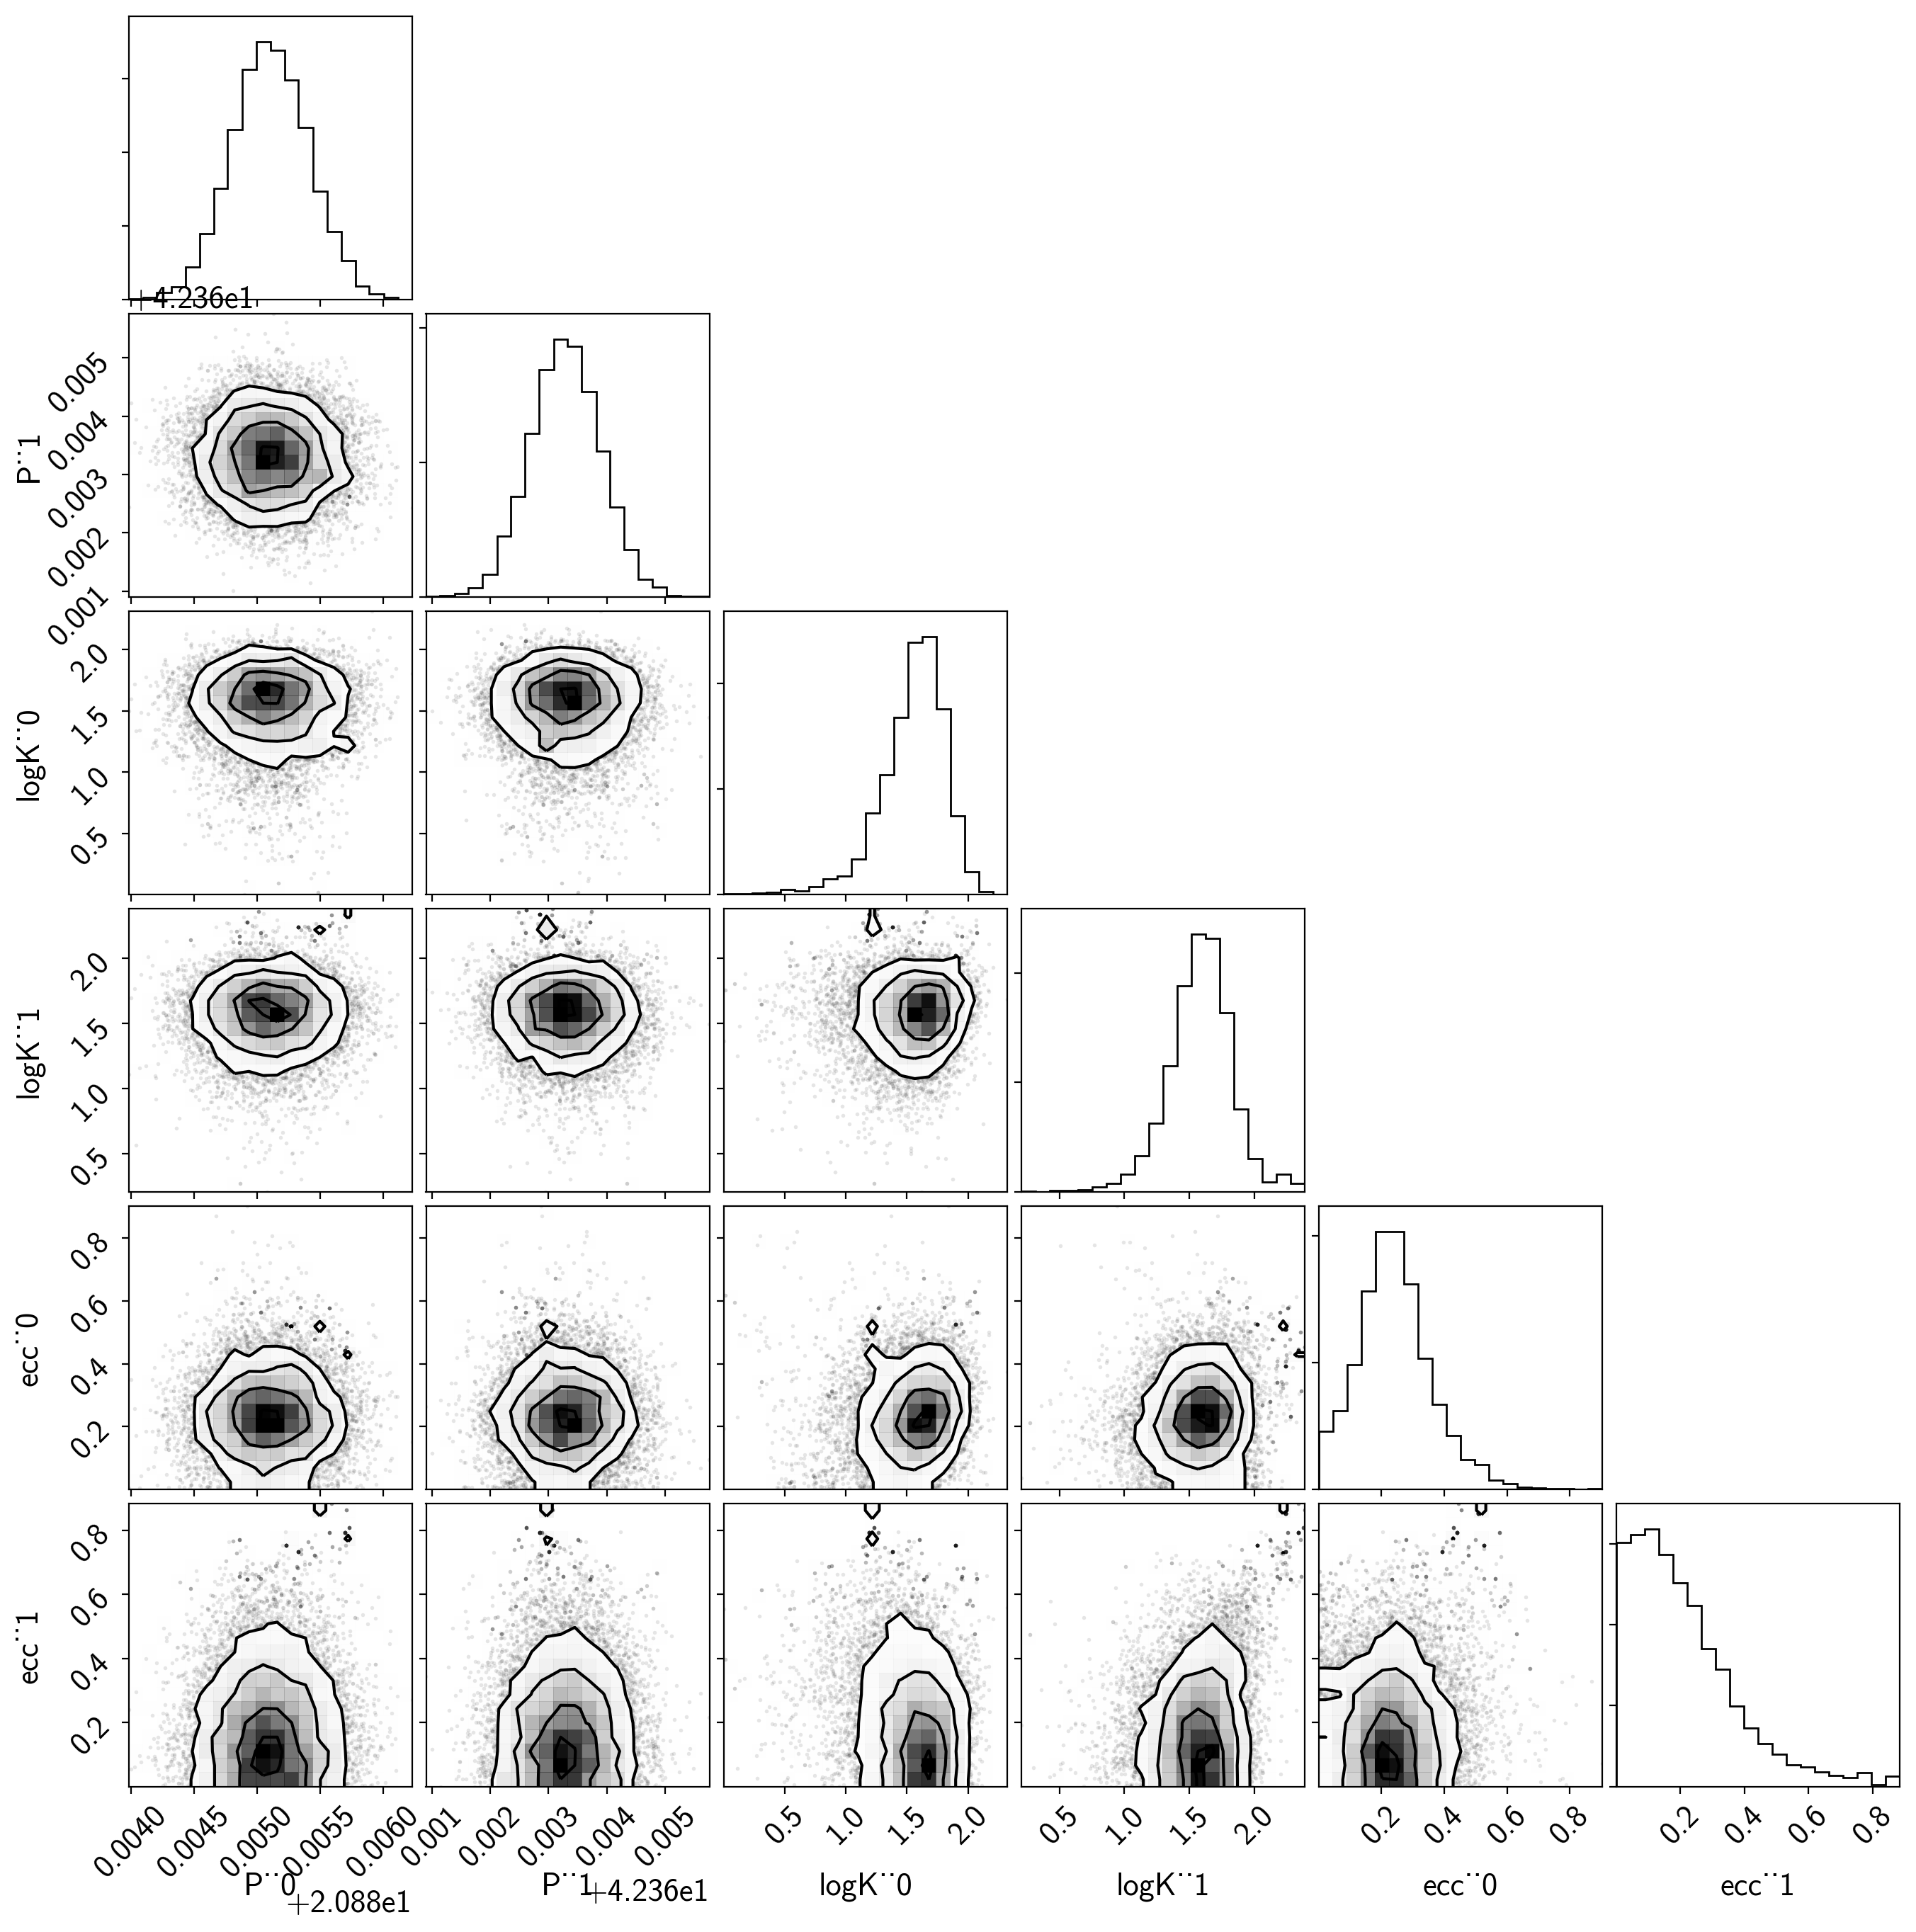

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

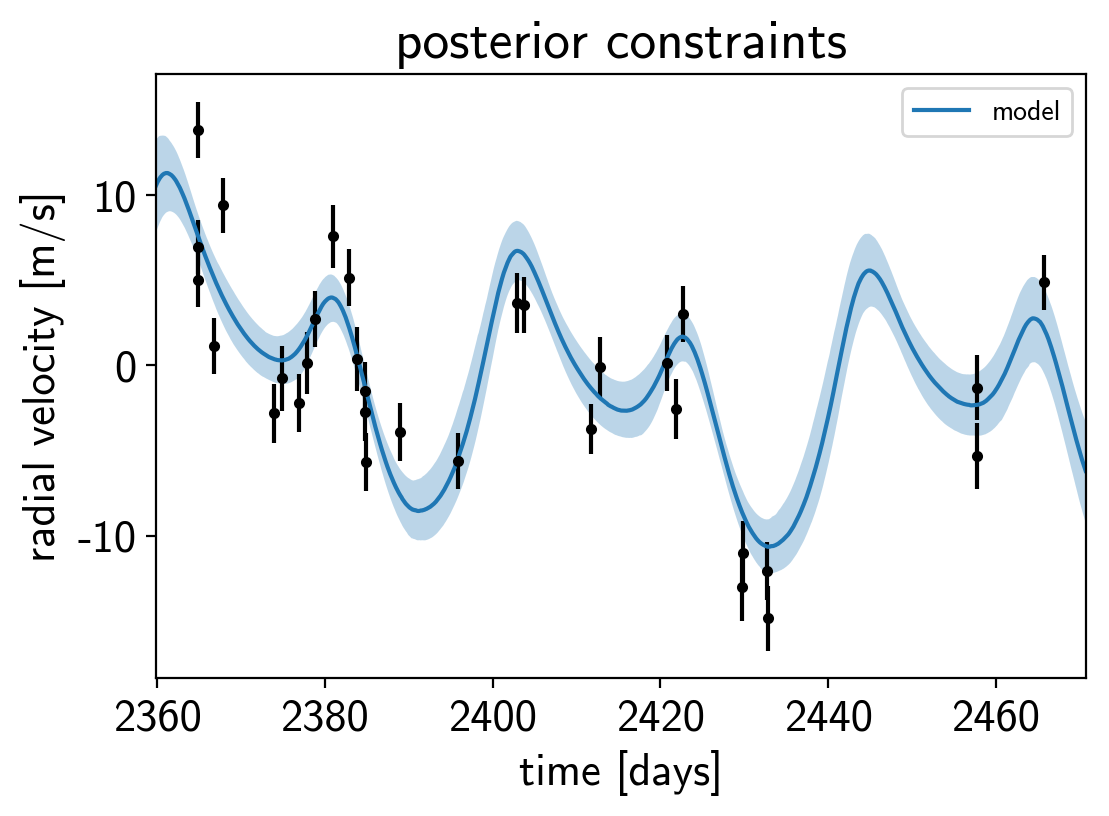

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

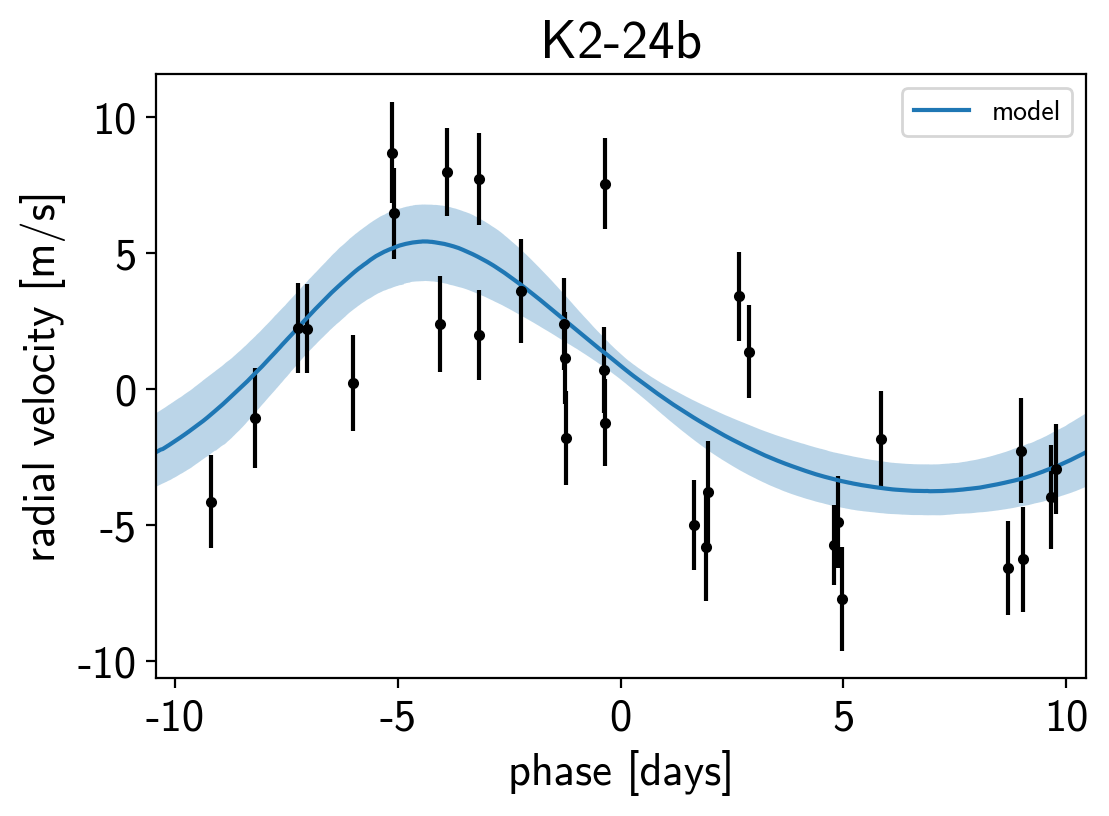

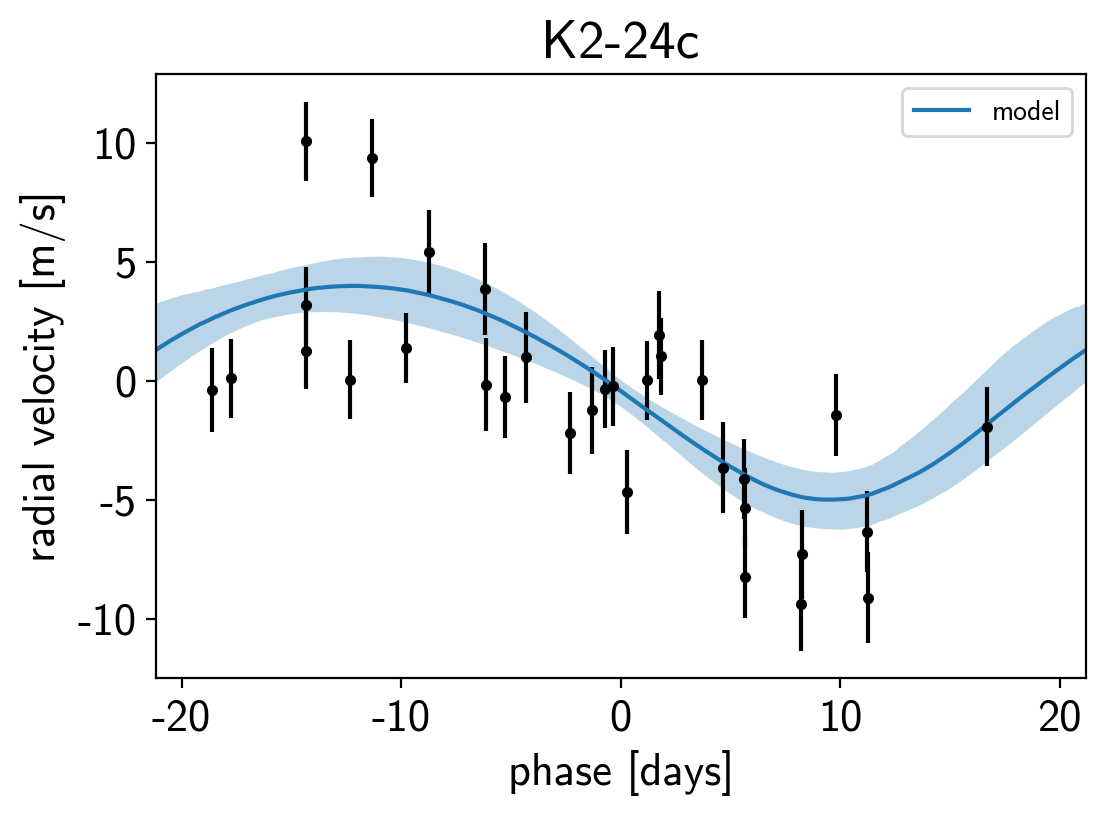

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));